# Neutron Burst

The neutron burst may happen in high mass stars during a supernova blast leaving behind characteristic nucleosynthesis signatures in presolar grains. The neutron burst occurs when neutron number densities are sufficiently high ($\sim 10^{17}$ neutrons/cm$^{-3}$) to capture up an isotopic chain in a manner similar to the r-process, though with much lower neutron exposures and therefore less neutron rich products. 

For a glipse at this kind of network, consider the following neutron capture chain:
\begin{gather}
1 + n \rightarrow 2 + \gamma\notag\\
2 + n \rightarrow 3 + \gamma\notag\\
3 + n \rightarrow 4 + \gamma\notag
\end{gather}

To solve this network numerically we have the coupled differential equations:
\begin{gather}
\frac{dY_1}{d\tau} = -\sigma_{n,1} Y_1\\
\frac{dY_2}{d\tau} = \sigma_{n,1} Y_1 - \sigma_{n,2}Y_2\\
\frac{dY_3}{d\tau} = \sigma_{n,2} Y_2 - \sigma_{n,3}Y_3\\
\frac{dY_4}{d\tau} = \sigma_{n,3} Y_3 
\end{gather}
where the $\sigma_n$ are the neutron capture cross sections for each species and $\tau$ is the neutron exposure (units of inverse area). 

For simplicity, this notebook considers an isolated reaction chain. In other words the only reactions considered are neutron captures along the chain and out of the chain.

## Solving the network 

We begin by importing the necessary libraries:

In [1]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy','wnutils', 'wnnet', 'matplotlib', 'gslconsts', 'scipy', 'ipywidgets', 'xmlcoll'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
import wnutils.xml as wx
import xmlcoll as xc
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
from gslconsts.consts import *
from scipy.integrate import solve_ivp

Now we define a function to integrate the network numerically:

In [2]:
def Y(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

Now, we import the data that will be used throughout this notebook. Execution of this cell will take a minute. The 'solar_xml' contains the mass fractions of isotopes in the solar system and the 'net' contains details on nuclear reaction rates for computing the neutron burst network. 

In [3]:
solar_xml = wx.Xml(
        io.BytesIO(requests.get("https://osf.io/w8ktc/download").content))
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

### Getting the initial abundances

As a starting point, we will take the initial abundances to be that of solar (Lodders 2020). To obtain the abundances we define a function that uses the 'solar_xml' to obtain the mass fractions when given a list of isotopes in the chain:

In [4]:
def get_solar_isotopes(isotopes):    
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    abunds = []
    a = []

    for isotope in isotopes:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        a.append(s_tup[2])
        if s_tup in x_solar:
            abunds.append(x_solar[s_tup] / tup[1])
        else:
            abunds.append(0)
            
    return a, abunds

Now we define a list of isotopes, which can be altered to whatever neutron capture chain is of interest to you. Additionally we define a dictionary which will later store the abundances.

In [5]:
species = ['ca40','ca41','ca42','ca43','ca44','ca45','ca46','ca47','ca48','ca49','ca50']
abund_dict = {}

Now we use the get_solar_isotopes function to populate the abundance dictionary. The keys will be the isotope names and the value will be the abundances:

In [6]:
a, solar_abunds = get_solar_isotopes(species)
for i in range(len(solar_abunds)):
    abund_dict[species[i]] = solar_abunds[i]

Finally, we can plot the initial abundances. Here any abundances less than $10^{-15}$ are ignored:

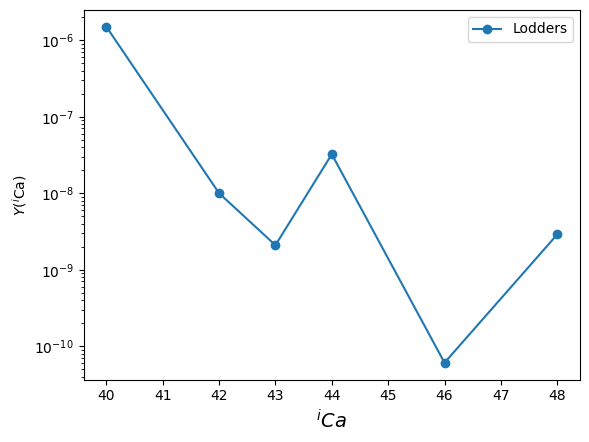

In [7]:
fig, ax = plt.subplots()
ax.plot([a[i] for i in range(len(solar_abunds)) if solar_abunds[i] >= 1e-15], 
        [vals for keys, vals in abund_dict.items() if vals >= 1e-15], 'o-', label = 'Lodders')
ax.set_yscale('log')
ax.set_xlabel(r'$^{i} Ca$', fontsize = 14)
ax.set_ylabel(r'$Y$($^i$Ca)') 
ax.legend()
plt.show()

### Plotting the abundances vs. neutron exposure 

We can use the initial abundances and the scipy.integrate function to solve the system of ODE's presented above. In order to do this we need to obtain the neutron capture cross sections ($\sigma_i$) using the wnnet package. 

First, we define a temperature in $10^9$K to be used to compute the reaction rates.

In [8]:
t9 = 3

Now, we compute the reaction rates for all neutron capture reactions at the provided temperature:

In [9]:
induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
reacs = net.compute_rates(t9, reac_xpath = induced_reac_xpath)
rates = []
for key, values in list(reacs.items()):
    rates.append(values[0])

Next, we can obtain a dictionary of the reactions for strictly the species in our reaction chain: 

In [10]:
ordered_dict = {}

for sp in species:
    for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
        if sp in value.reactants:
            ordered_dict[sp] = reacs[key][0]

Now that we have obtained the rates, we can get the cross sections by noting:
\begin{gather}
r(T) = N_A <\sigma v>(T)
\end{gather}
and the thermal velocity is given by:
\begin{gather}
v_T = \sqrt{\frac{2k_BT}{m_n}}
\end{gather}
which represents the most probable velocity in a Maxwell-Boltzmann distribution. We then compute the cross sections:

In [11]:
k = GSL_CONST_CGS_BOLTZMANN
N_A = GSL_CONST_NUM_AVOGADRO
m_n = GSL_CONST_CGS_MASS_NEUTRON

T = t9 * 10**9
v_T = np.sqrt((2*k*T)/m_n)

sigs_array = []
for key, value in ordered_dict.items():
    sigs_array.append(1000*value/(v_T*N_A*wn.consts.GSL_CONST_CGSM_BARN))

Finally we solve the network using the solve_ivp function and plot the results:

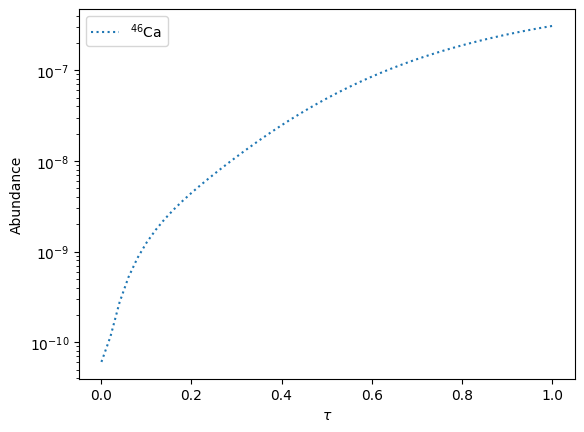

In [12]:
tau = np.linspace(0.001, 1, 100)

sol = solve_ivp(Y, [tau[0], tau[len(tau)-1]], solar_abunds, args=(sigs_array,), max_step=0.02)
sol_dict = {}
for i in range(len(species)):
    sol_dict[species[i]] = sol.y[i]

#plot results
fig, ax = plt.subplots()
ax.plot(sol.t, sol_dict['ca46'], ':', label = solar_xml.get_latex_names(['ca46'])['ca46'])
ax.set_yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel('Abundance')
plt.show()

### Exploring final abundances 
Now we would like to explore the final abundances of all isotopes in the chain subject to different exposures. One would also likely want initial abundances to be near solar, however varying the initial compositions can impact the final abundances to more accurately describe the abundances observed in presolar grains. 

First, we define a few functions to create the interactive plot:

In [13]:
def solve_ode_ivp(abundances, tau):
    y0 = list(abundances.values())  # Initial conditions
    tau_range = np.linspace(0.001, 1, 100)

    # Solve the ODE using solve_ivp
    sol = solve_ivp(
        Y, 
        (tau_range[0], tau_range[len(tau_range)-1]), 
        y0, 
        t_eval=tau,
        args=(sigs_array,)
    )
    y_dict = {}
    for i in range(len(species)):
        y_dict[species[i]] = sol.y[i]

    return y_dict

def plot_nuclear_network(tau, isotope_abundances, **percent_changes):
    # Adjust the abundances based on the percentage changes
#    adj_abundances = {isotope: abundance * (1 + percent_changes[isotope + '_percent'] / 100)
#                      for isotope, abundance in isotope_abundances.items()}
    abunds = [vals for keys, vals in isotope_abundances.items()]

    # Solve the ODE with the adjusted abundances and given tau
    sol = solve_ode_ivp(isotope_abundances, [tau])
    solution = list(sol.values())
    fig, ax = plt.subplots()
    ax.plot([a[i] for i in range(len(abunds)) if abunds[i] !=0], 
        [vals for keys, vals in isotope_abundances.items() if vals != 0], 'o-', label = 'Lodders')

    ax.plot([a[i] for i in range(len(solution)) if solution[i] > 1e-20], 
            [sols for sols in solution if sols > 1e-20], 'o-', label = 'Network')
    ax.set_xticks(range(min(a), max(a) + 1, 1))
    ax.set_xlabel(r'$^{i}Ca$')  #Modify element symbol for different abundance chain
    ax.set_ylabel('Abundance')
    ax.set_title(f'(τ={tau}) (mb-1)')
    ax.set_yscale('log')
    ax.legend()
    plt.show()
    ax.clear()
    
def create_interactive_plot(isotope_abundances):
#    sliders = {}
##    for isotope in isotope_abundances:
 #       sliders[isotope + '_percent'] = widgets.BoundedFloatText(
 #           value=0, min=-100, max=100, step=1, description=f'{solar_xml.get_latex_names([isotope])[isotope]} (% change)'
 #       )

    # Use `interact` to dynamically create the plot with adjustable parameters
    interact(
        plot_nuclear_network,
        tau=widgets.BoundedFloatText(value=.01, min=0.001, max=1.0, step=(1-0.001)/100, description='τ'),
        isotope_abundances=fixed(isotope_abundances),
#        **sliders
    )

Now, we create the interactive plot. The widgets can be used to vary the neutron exposure $\tau$:

In [14]:
create_interactive_plot(abund_dict)

interactive(children=(BoundedFloatText(value=0.01, description='τ', max=1.0, min=0.001, step=0.00999), Output(…

## Comparison to data
Here we compare the results of the neutron burst network calculation to that of presolar grain data. Grain data is reported in abundance ratios or by $\delta$ values given by for example a calcium isotope:
\begin{gather}
\delta(^{i}Ca) = \Big(\frac{\big(\frac{^iCa}{^{40}Ca} \big)_{meas}}{\big(\frac{^iCa}{^{40}Ca} \big)_\odot} -1\Big)\times 10^3 
\end{gather}

Which can be arranged to give:
\begin{gather}
\frac{\delta(^iCa)}{10^3}+1 = \Big( \frac{^iCa_{meas}}{^iCa_\odot} \frac{^{40}Ca_{\odot}}{^{40}Ca_{meas}} \Big)
\end{gather}

This relationship allows for us to compare grain data (reported in $\delta$ values) to network results. First, input your data into the following dictionary. The dictionary keys are an isotope name given by: 'symbolA', where 'symbol' is the lowercase atomic symbol and 'A is the mass number. The values are tuples of ($\delta$ value, error). 

In [20]:
data_dict = {
            'ca42': (318, 44),
            'ca43' : (1488, 141),
            'ca44' : (98, 23),
            'ca46' : (34091, 2110), 
#            'ca48' : (-235, 41)
            }

Now, we can define a function to input the results of the reaction network and a normalizing species which will return the data for the comparison plot. For example, if you have grain data for calcium isotopes where the $\delta$ values are normalized with $^{40}Ca$ then to compare network results to this grain data you need:
\begin{gather}
\frac{^iCa_{net}}{^iCa_\odot} \frac{^{40}Ca_{\odot}}{^{40}Ca_{net}}
\end{gather}

In [21]:
def get_normalized(abund_dict, norm_species):
    solar = solar_xml.get_zone_data()
    x_solar = solar['0']['mass fractions']
    
    norm_id = solar_xml.get_z_a_state_from_nuclide_name(norm_species)
    norm_key = (norm_species, norm_id[0], norm_id[1])
    
    ratio = x_solar[norm_key]/(abund_dict[norm_species] * norm_id[1])
    
    plot_data = {}
    for keys in abund_dict:
        tup = solar_xml.get_z_a_state_from_nuclide_name(keys)
        s_tup = (keys, tup[0], tup[1])
        if s_tup in x_solar:
            plot_data[keys] = (abund_dict[keys]*tup[1])/x_solar[s_tup] * ratio
        else:
            plot_data[keys] = 0
    return plot_data

Next, we define a function that uses the LHS of the above equation to get the grain data in a form that we can compare to the network:

In [22]:
def convert_grain_data(grain_data):
    a_grain = []
    data_grain = []
    err_grain = []
    for keys in grain_data:
        a_grain.append(solar_xml.get_z_a_state_from_nuclide_name(keys)[1])
        data_grain.append(grain_data[keys][0]/1e3 + 1)
        err_grain.append(grain_data[keys][1]/1e3)
    return a_grain, data_grain, err_grain

Finally, we define two functions to create the interactive plot:

In [23]:
def compare_nuclear_network(tau, isotope_abundances, **percent_changes):
    # Adjust the abundances based on the percentage changes
    adj_abundances = {isotope: abundance * (1 + percent_changes[isotope + '_percent'] / 100)
                      for isotope, abundance in isotope_abundances.items()}
    abunds = [vals for keys, vals in adj_abundances.items()]
    
    # Solve the ODE with the adjusted abundances and given tau
    sol = solve_ode_ivp(adj_abundances, [tau])
    norm_data = get_normalized(sol, 'ca40')
    solution = [vals for keys, vals in norm_data.items()]
    
    a_g, d_g, e_g = convert_grain_data(data_dict)
    
    fig, ax = plt.subplots()
    ax.errorbar(a_g, d_g, yerr = e_g, fmt = 'o-', label = "Grains")

    ax.plot([a[i] for i in range(len(abunds)) if solution[i] > 1e-15], 
            [sols for sols in solution if sols > 1e-15], 'o-', label = 'Network')
    
    ax.set_xlabel(r'$^{i}Ca$')  #Modify element symbol for different abundance chain
    ax.set_ylabel('Abundance')
    ax.set_title(f'(τ={tau}) (mb-1)')
    ax.set_yscale('log')
    ax.legend()
    plt.show()
    ax.clear()
    
def create_comparison_plot(isotope_abundances):
    sliders = {}
    for isotope in isotope_abundances:
        sliders[isotope + '_percent'] = widgets.BoundedFloatText(
            value=0, min=-100, max=100, step=1, description=f'{solar_xml.get_latex_names([isotope])[isotope]} (% change)'
        )

    # Use `interact` to dynamically create the plot with adjustable parameters
    interact(
        compare_nuclear_network,
        tau=widgets.BoundedFloatText(value=.01, min=0.001, max=0.1, step=(1-0.001)/1000, description='τ'),
        isotope_abundances=fixed(isotope_abundances),
        **sliders
    )

In [24]:
create_comparison_plot(abund_dict)

interactive(children=(BoundedFloatText(value=0.01, description='τ', max=0.1, min=0.001, step=0.000999), Bounde…